# import packages 

In [1]:
import hifive
import numpy as np 
import matplotlib.pyplot as plt


# get matrix

In [2]:
hic=hifive.HiC('3DGenomeData/data/project_file', 'r')
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)
data += 1

Finding fend full array for chr13:1000000-120250001... Done


# find and fix enrichment 

In [3]:
enrichment = (data[:, :, 0] / data[:, :, 1])
log_enrich=np.log(enrichment)

# make heatmap of chromosome 13 enrichment 

<Figure size 432x288 with 0 Axes>

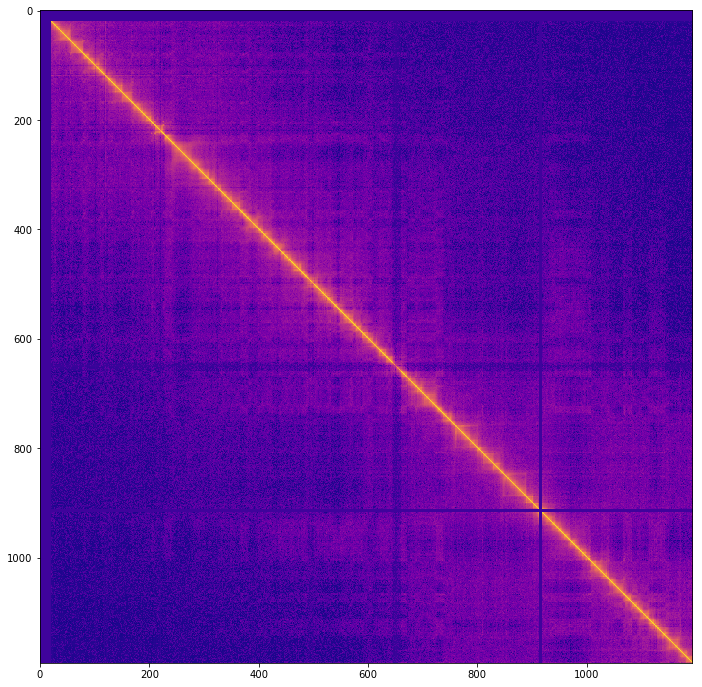

In [4]:
#matplotlib.pyplot.imshow(enrichment)
fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(12,12))
heatplot = ax.imshow(log_enrich, cmap='plasma')
#ax.set_xticklabels(log_enrich.columns)
#ax.set_yticklabels(log_enrich.index)

# compartment analysis

In [5]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Casting complex values to real discards the imaginary part


# Compartment score plot 

Casting complex values to real discards the imaginary part


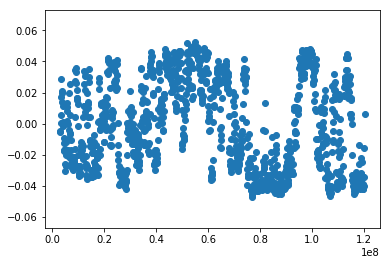

In [6]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']
X2=[]
for i in X: 
    for a in i:
        X2.append(a)
X2=X2[::2]

plt.scatter(X2,Y)
plt.show()

#separate them based on all the eigenvectors for each gene 
#use FPKM file in the data folder to find the gene name and start/stop positions 

# arrange data for violin plots

In [7]:
#separate by positive and negative compartment values
bed=open('bedtools_insersect.bed', 'r')
keys=[]
comp=[]
FPKM=[]
gene_start=[]
gene_stop=[]

for i in bed: 
    split=i.split()
    #print(split)
    keys.append(split[7])
    comp.append(split[3])
    FPKM.append(split[8])
    gene_start.append(split[5])
    gene_stop.append(split[6])
    
zipped=zip(keys, comp)
dictionary=dict(zipped)
positive_keys=[]
negative_keys=[]
for key,value in dictionary.items():
    if "-" in value: 
        negative_keys.append(key)
    else: 
        positive_keys.append(key)
            

In [8]:
bed=open('bedtools_insersect.bed', 'r')
FPKM_positive=[]
FPKM_negative=[]

zip3=[]
zip2= zip(keys, FPKM)
for i in zip2:
    if i not in zip3: 
        zip3.append(i)

for i in negative_keys:
    for x in zip3:
        if i in x: 
            FPKM_negative.append(float(x[1]))
for i in positive_keys:
    for x in zip3:
        if i in x: 
            FPKM_positive.append(float(x[1]))
positive_log_FPKM=[]
negative_log_FPKM=[]
for i in FPKM_positive:
    log=np.log2(i+1)
    positive_log_FPKM.append(log)
for i in FPKM_negative:
    log=np.log2(i+1)
    negative_log_FPKM.append(log)
    

# violin plots

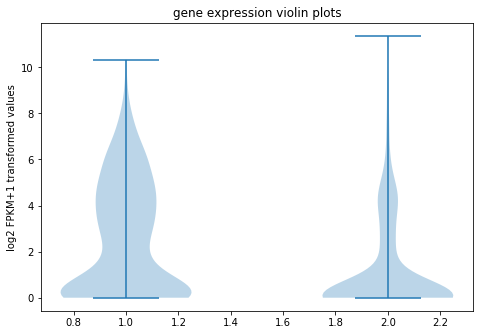

In [9]:
labels=[positive_log_FPKM,negative_log_FPKM]

data=[positive_log_FPKM, negative_log_FPKM]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('gene expression violin plots')
ax.set_ylabel('log2 FPKM+1 transformed values')
bp = ax.violinplot(data)

plt.show()

# Expression versus repression

In [10]:
import pyBigWig
A_comp_methylation=[]
B_comp_methylation=[]

#make dictionary with genes as keys, and the gene coordinates as values 
zipped_coords=zip(gene_start,gene_stop)
zipped_coords=zip(keys, zipped_coords)
coordinate_dict=dict(zipped_coords)

#go through the dictionary keys with genes from the positive and negative compartments 
for key, value in coordinate_dict.items():
    
    #if a gene is in this compartment, define start and stop values, loop through pyBigWig, and append to a list 
    if key in positive_keys:
        start= int(value[0])
        stop=int(value[1])
        gene=key
        bw = pyBigWig.open('3DGenomeData/data/WT_H3K27me3.bw')
        repression= bw.stats('chr13', start, stop, type='sum')
        A_comp_methylation.append(repression[0])
    
    if key in negative_keys:
        start= int(value[0])
        stop=int(value[1])
        gene=key
        bw = pyBigWig.open('3DGenomeData/data/WT_H3K27me3.bw')
        repression= bw.stats('chr13', start, stop, type='sum')
        B_comp_methylation.append(repression[0])

#convert None to '0'
A_comp_methylation = [str(i or '0') for i in A_comp_methylation] 
B_comp_methylation=[str(i or '0') for i in B_comp_methylation] 

#log2(H3K27me3 +1) transformation
A_comp_log2=[]
B_comp_log2=[]
for i in A_comp_methylation:
    log=np.log2(float(i)+1)
    A_comp_log2.append(log)
for i in B_comp_methylation:
    log=np.log2(float(i)+1)
    B_comp_log2.append(log)

# make scatter plots

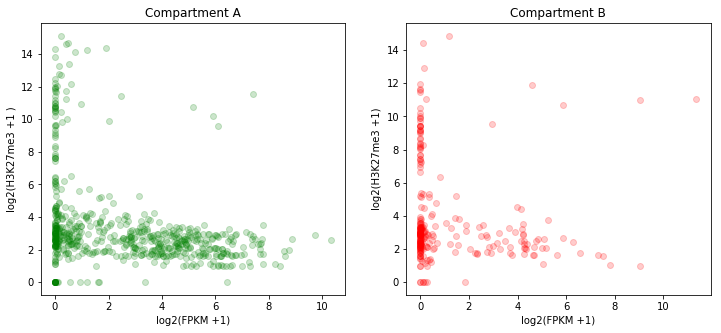

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(positive_log_FPKM, A_comp_log2, alpha=.2, color='green')
ax[1].scatter(negative_log_FPKM, B_comp_log2, alpha=.2, color='red')

ax[0].set_ylabel('log2(H3K27me3 +1 )')
ax[0].set_xlabel('log2(FPKM +1)')

ax[1].set_ylabel('log2(H3K27me3 +1)')
ax[1].set_xlabel('log2(FPKM +1)')

ax[0].set_title('Compartment A')
ax[1].set_title('Compartment B')

plt.show()